In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix
import hashlib
from collections import defaultdict
from itertools import combinations


In [5]:
file  = np.load('user_movie_rating.npy')
user_id = file[:,0]
movie_id = file[:,1]
rating = file[:,2]

count_ones = np.sum(user_id == 1)
count_twos = np.sum(user_id == 2)
print(count_ones)

similarity_threshold = 0.5
print(len(movie_id))
print(movie_id[count_ones+count_twos-1:])
print(file)

626
65225506
[17764    30    84 ... 17622 17627 17764]
[[     1     30      3]
 [     1    157      3]
 [     1    173      4]
 ...
 [103703  17622      2]
 [103703  17627      4]
 [103703  17764      4]]


In [44]:
#create a sparse matrix of the user-movie rating, where the movies that recieved a rating get a 1 and the ones that did not get a rating get a 0
#We assume from the assignment that we only care about movies that were rated but not the actual ratings. Thus giving a binary matrix

def create_matrix(file):
    user_id = file[:,0]
    movie_id = file[:,1]
    rating = file[:,2]
    data = np.ones(len(rating))
    user_movie_matrix = csc_matrix((data, (movie_id, user_id))) #heb movie en user omgedraaid, omdat we de users als colommen willen hebben
    return user_movie_matrix

In [45]:
user_movie_matrix = create_matrix(file)
#delete the first row and column since they are empty
user_movie_matrix = user_movie_matrix[1:,1:]
# print(user_movie_matrix)
# print(user_movie_matrix.shape)

print(user_movie_matrix.toarray()[27:31,0:3]) #to see the axes of the matrix

[[0. 1. 0.]
 [0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


Note: Ik heb nu de binary matrix getransposed om de de users als kolommen en movies als rijen willen.

In [5]:
#make a minhash function for the csc matrix, I realise now that a csr matrix might have been more efficient
def minhash(data, num_permutations):
    if not isinstance(data, csc_matrix):
        raise ValueError("Input data must be a scipy.sparse CSC matrix.")
    
    num_movies = data.shape[1]  # Number of columns (features)
    num_users = data.shape[0]   # Number of rows (samples)
    
    # Create random permutations
    permutations = [np.random.permutation(num_movies) for _ in range(num_permutations)]
    perm_signature = np.full((num_users, num_permutations), np.inf)
    
    # Iterate over columns (movies/features) of the CSC matrix
    for movie_index in range(num_movies):
        # Get all non-zero row indices for the current column
        row_indices = data.indices[data.indptr[movie_index]:data.indptr[movie_index + 1]]
        
        for k in range(num_permutations):
            # Compute the hash value for the current column (movie_index)
            hash_value = permutations[k][movie_index]
            
            # Update the MinHash signature for the rows with non-zero values in this column
            for row_index in row_indices:
                perm_signature[row_index, k] = min(perm_signature[row_index, k], hash_value)

    return perm_signature



In [ ]:
hash = minhash(user_movie_matrix, 100)
np.save('minhash_2.npy', hash)

# #save the minhash signature to a file
#np.save('minhash_transposed.npy', testhash)
testhash = np.load('minhash_transposed.npy')
testh = np.load('minhash.npy')
print(testhash)
print(testhash.shape)
print(testh.shape)


[[2.430e+02 6.200e+01 6.200e+01 ... 6.480e+02 1.070e+02 6.190e+02]
 [9.320e+02 2.167e+03 6.200e+01 ... 2.658e+03 1.209e+03 1.688e+03]
 [9.000e+01 9.000e+00 2.000e+00 ... 1.500e+01 1.200e+01 3.300e+01]
 ...
 [1.800e+02 1.030e+02 1.040e+02 ... 6.700e+01 4.500e+01 1.740e+02]
 [6.000e+00 2.500e+01 1.100e+01 ... 5.500e+01 3.000e+01 5.900e+01]
 [5.200e+01 4.330e+02 2.940e+02 ... 2.200e+01 1.700e+02 1.980e+02]]
(17770, 100)
(100, 103703)


[[2.430e+02 6.200e+01 6.200e+01 ... 6.480e+02 1.070e+02 6.190e+02]
 [9.320e+02 2.167e+03 6.200e+01 ... 2.658e+03 1.209e+03 1.688e+03]
 [9.000e+01 9.000e+00 2.000e+00 ... 1.500e+01 1.200e+01 3.300e+01]
 ...
 [1.800e+02 1.030e+02 1.040e+02 ... 6.700e+01 4.500e+01 1.740e+02]
 [6.000e+00 2.500e+01 1.100e+01 ... 5.500e+01 3.000e+01 5.900e+01]
 [5.200e+01 4.330e+02 2.940e+02 ... 2.200e+01 1.700e+02 1.980e+02]]
(17770, 100)
<class 'numpy.ndarray'>


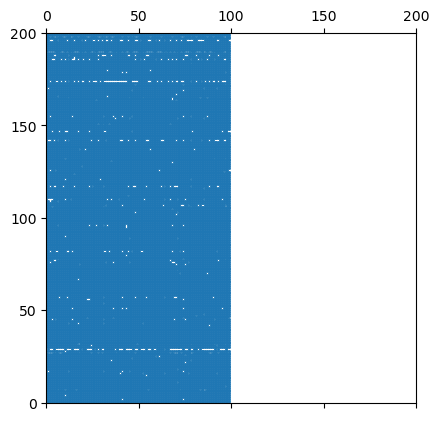

In [41]:
print(testhash)
print(testhash.shape)
print(type(testhash))
#show that the matrix has 100 columns and 17770 rows as i always forget which is which lol
#meaning columns are the users and rows are the permutations
#the rows typically refer to the first axis (axis 0), and the columns refer to the second axis (axis 1). 

plt.spy(testhash, markersize=1)
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.show()

In [8]:
#print the first colum from the user_movie_matrix, so for the first person
print(user_movie_matrix[0,:])
print(testhash[:,0])

NameError: name 'user_movie_matrix' is not defined

In [ ]:


# def lsh(signatures, num_hashes, similarity_threshold):
#     num_bands = 50
#     band_size = num_hashes // num_bands

#     buckets = {}
#     for user_id, signature in enumerate(signatures):
#         for band in range(num_bands):
#             band_hash = tuple(signature[band * band_size:(band + 1) * band_size])
#             if band_hash not in buckets:
#                 buckets[band_hash] = []
#             buckets[band_hash].append(user_id)
    
#     print(f'Amount of buckets: {len(buckets)}')
    
#     candidate_pairs = set()
#     for bucket_users in buckets.values():
#         for i in range(len(bucket_users)):
#             for j in range(i + 1, len(bucket_users)):
#                 candidate_pairs.add((bucket_users[i], bucket_users[j]))
    
#     print(f'Candidate pairs: {len(candidate_pairs)}')
    
#     similar_users = []
#     for user1, user2 in candidate_pairs:
#         if user1 == user2:
#             continue
#         sim = jaccard_similarity(signatures[user1], signatures[user2])
#         if sim >= similarity_threshold:
#             similar_users.append((user1, user2))
    
#     print(f'Similar users: {len(similar_users)}')
#     return similar_users

In [ ]:
# def hash_with_hashlib(row, num_buckets):
#     # Convert row to a string representation
#     row_str = ",".join(map(str, row))
#     # Hash the string using hashlib
#     hash_object = hashlib.sha256(row_str.encode())
#     # Convert hash to an integer
#     hash_int = int(hash_object.hexdigest(), 16)
#     # Map to a bucket
#     return hash_int % num_buckets

# def LocalSH(signatures, num_bands, num_buckets, similarity_threshold):
#     #first we split the matrix into bands , we need to make sure that the number of bands times the number of rows per band is equal to the number of rows in the signature matrix
#     if signatures.shape[1] % num_bands != 0:
#         raise ValueError("The number of columns must be divisible by m for exact band splitting.")

#     bands = np.split(signatures, num_bands, axis=1) #split the signature array along the second axis (colums)
#     print(f'# values in each band: {bands[0].shape[1]}')

#     #we will use hashlib to get a unique hash for each band

#     bucket_table = []
#     for band in enumerate(bands):
#         buckets = defaultdict(list)

#         for i, row in enumerate(band):
#             bucket = hash_with_hashlib(band, num_buckets)
#             buckets[bucket].append(i)
#         bucket_table.append(buckets)
#         #this should give us a table with the buckets for each band
#     for bucket, rows in bucket_table[0].items():
#         print(f'Bucket {bucket}: {rows}')





In [20]:
#define functions to use in the LSH function


def jaccard_similarity(signature1, signature2):
    
    #returns the jaccard similarity between two signatures

    return np.sum(signature1 == signature2) / np.sum(signature1 != np.inf)

def split_vector(signature, num_bands):

    #split the signature matrux in to bands

    column_size = signature.shape[0] // num_bands

    #validate that the number of columns is divisible by the number of bands

    if signature.shape[1] % num_bands != 0:
        raise ValueError(f"The number of columns {signature.shape[0]} must be divisible by the number of bands {num_bands} for exact band splitting.")
    
    split_arrays = np.hsplit(signature, signature.shape[0]//column_size)
    print([sub_array.shape for sub_array in split_arrays])
    return split_arrays


def Hash_band(column, num_buckets):
    #convert the array to a string and hash it
    column_str = ",".join(map(str, column))
    return hash(column_str) % num_buckets

def LSH(signature, num_bands, num_buckets, similarity_threshold):

    #split the signature matrix into bands
    split_arrays = split_vector(signature, num_bands)
    #create a dictionary for the buckets
    hashbucketdict = {}

    #populate the dictionary with the bucket its hashed in for each band
    for i in range(len(split_arrays)):
        hashbucketdict[f'hash{i}'] = np.apply_along_axis(Hash_band, 1, split_arrays[i], num_buckets=num_buckets)
    
    #create a dictionary to store the indices of the buckets
  

    #populate the dictionary with the entire hashbucketdict
    for i in range(len(split_arrays)):
        bucket_groups = defaultdict(list)
        for idx, bucket in enumerate(hashbucketdict[f'hash{i}']):
            bucket_groups[bucket].append(idx)
    #filter out any bucket with only a single index occupying it
    filtered_buckets = {bucket: indices for bucket, indices in bucket_groups.items() if len(indices) > 1 }
    print(f'the amount of buckets with multiple values: {len(filtered_buckets)}')

    #create a dictionary to store the jaccard similarity between the users
    jaccard_similarity_dict = {}

    #iterate over the filtered buckets and calculate the jaccard similarity between the users
    for bucket, indices in filtered_buckets.items():

        #get all possible combinations of the indices in the bucket and calculate the jaccard similarity
        for set1, set2 in combinations(indices, 2):
            similarity = jaccard_similarity(signature[set1,:], signature[set2,:])

            #allow only similarities higher than the set threshold to be stored
            if similarity > similarity_threshold:
                jaccard_similarity_dict[f'users: {set1}, {set2}'] = similarity

    return jaccard_similarity_dict



In [37]:
jaccard_dict = LSH(testhash, 10, 500, 0.5)

[(17770, 10), (17770, 10), (17770, 10), (17770, 10), (17770, 10), (17770, 10), (17770, 10), (17770, 10), (17770, 10), (17770, 10)]
the amount of buckets with multiple values: 500


In [36]:
len(jaccard_dict)

59